# Предсказание стоимости жилья


ПОСТАНОВКА ЗАДАЧИ


Исходные данные: Компания предоставила данные, включающие характеристики недвижимости в Калифорнии, такие как месторасположение (долгота и широта), общая площадь, удаленность от моря, количество комнат, количество спален, количество людей в населенном пункте.

Цель исследования: В проекте нужно обучить модель линейной регрессии на данных о жилье в Калифорнии в 1990 году. 

Задачи исследования:

На основе данных нужно предсказать медианную стоимость дома в жилом массиве — median_house_value. Обучить модель и сделать предсказания на тестовой выборке. Для оценки качества модели используйте метрики RMSE, MAE и R2. необходимо построить две модели линейной регрессии на разных наборах данных: 
o	используя все данные из файла;
o	используя только числовые переменные, исключив категориальные.
Для построения модели используйте оценщик LinearRegression из библиотеки MLlib.


Исследование будет включать в себя следующие этапы:

Обзор данных:

Загрузка и первичный анализ предоставленных файлов данных.
Оценка качества данных и выявление потенциальных проблем.
Предобработка данных:

Исправление обнаруженных ошибок и пропусков.
Преобразование типов данных для последующего анализа.
Исследовательский анализ данных (EDA):

Анализ распределений и взаимосвязей ключевых переменных.
Выявление факторов, потенциально влияющих на стоимость жилья.
Подготовка данных для моделирования:

Кодирование категориальных признаков.
Масштабирование числовых данных.
Построение и оценка моделей машинного обучения:

Разработка и обучение модели для предсказания уровня стоимости жилья.
Создание и оценка модели для прогнозирования стоимости жилья.
Оценка качества моделей.
Анализ результатов и выработка рекомендаций:

Интерпретация результатов прогнозирования.
Визуализация результатов:

Графическое представление важнейших находок и результатов моделирования.
Итоговые выводы и рекомендации:

Формулирование ключевых выводов исследования.

Исследование предоставит комплексный анализ уровня стоимости жилья и факторов, влияющих на таргет.

# 1. Загрузка и первичный обзор данных


## Импорт библиотек и настройка графиков

In [1]:
! pip install pyspark

In [5]:
import pandas as pd 
import numpy as np
import warnings
warnings.filterwarnings("ignore")

import pyspark
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col, mean

from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics


from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import Imputer, StringIndexer, VectorIndexer, VectorAssembler, PCA, Bucketizer, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.linalg import Vectors
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator


pyspark_version = pyspark.__version__
if int(pyspark_version[:1]) == 3:
    from pyspark.ml.feature import OneHotEncoder    
elif int(pyspark_version[:1]) == 2:
    from pyspark.ml.feature import OneHotEncodeEstimator

#import pandas_profiling
import ydata_profiling
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from scipy import stats
from scipy.stats import norm, skew

from phik import phik_matrix
from phik.report import plot_correlation_matrix


RANDOM_SEED = 2022


## Используемые функции

In [6]:
def chaddock_scale(df, method=None, phik=False):
    # Вычисляем и выводим коэффициент корреляции
    if phik == True:
        correlation_matrix = df.phik_matrix()
    else:
        correlation_matrix = df.corr(method=method)
    
    # Создаем список для хранения информации о каждой паре столбцов
    correlations = []
    
    # Получаем размерность матрицы корреляции
    n_rows, n_cols = correlation_matrix.shape

    # Определение тесноты связи и интерпретации для каждой пары столбцов
    for i in range(n_cols):
        for j in range(i + 1, n_cols):
            correlation_coefficient = correlation_matrix.iloc[i, j]

            # Определение тесноты связи
            abs_corr = abs(correlation_coefficient)
            strength_categories = ["Слабая", "Умеренная", "Заметная", "Высокая", "Весьма высокая", "Совершенная"]
            thresholds = [0.3, 0.5, 0.7, 0.9, 1, 1]  
            strength = next(
                category for category, threshold in zip(strength_categories, thresholds)
                if abs_corr <= threshold 
            )


            # Интерпретация
            interpretation = "Прямая" if correlation_coefficient > 0 else "Обратная"
            interpretation += " связь"
            
            # Добавляем информацию о каждой паре столбцов в список, если корреляция высокая или очень высокая
            if strength in ["Заметная", "Высокая", "Весьма высокая"]:
                correlations.append((
                    correlation_coefficient, 
                    strength, 
                    interpretation, 
                    correlation_matrix.columns[i],
                    correlation_matrix.columns[j]
                                    ))

    # Сортируем список по убыванию коэффициента корреляции
    correlations.sort(reverse=True)
    
    # Выводим информацию о каждой паре столбцов
    for corr_info in correlations:
        correlation_coefficient, strength, interpretation, col1, col2 = corr_info
        print()
        print(f"Для столбцов '{col1}' и '{col2}':")
        print("Коэффициент корреляции:", correlation_coefficient.round(3))
        print("Теснота связи:", strength)
        print("Тип связи:", interpretation)

## Загрузка данных

In [7]:
import os
for dirname, _, filenames in os.walk('/datasets/housing'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [8]:
spark = SparkSession.builder \
                    .master("local") \
                    .appName("housing_price_model") \
                    .getOrCreate()

In [9]:
df_housing = spark.read.csv("/datasets/housing.csv", header=True, inferSchema=True)

df_housing.show(3)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR BAY|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|       8.3014|          358500.0|       NEAR BAY|
|  -122.24|   37.85|              52.0|     1467.0|         190.0|     496.0|     177.0|       7.2574|          352100.0|       NEAR BAY|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
only showing top 3 rows



Согласно документации к данным df_housing мы имеем 10 столбцов :

•	longitude — широта;
•	latitude — долгота;
•	housing_median_age — медианный возраст жителей жилого массива;
•	total_rooms — общее количество комнат в домах жилого массива;
•	total_bedrooms — общее количество спален в домах жилого массива;
•	population — количество человек, которые проживают в жилом массиве;
•	households — количество домовладений в жилом массиве;
•	median_income — медианный доход жителей жилого массива;
•	median_house_value — медианная стоимость дома в жилом массиве;
•	ocean_proximity — близость к океану.

In [10]:
# выведите названия колонок 
print(pd.DataFrame(df_housing.dtypes, columns=['column', 'type']).head(10))

# выведите первые 10 строк 
df_housing.show(3)

               column    type
0           longitude  double
1            latitude  double
2  housing_median_age  double
3         total_rooms  double
4      total_bedrooms  double
5          population  double
6          households  double
7       median_income  double
8  median_house_value  double
9     ocean_proximity  string
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR BAY|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|       8.3014|          358500

In [11]:
df_housing.distinct().toPandas() 

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.28,37.81,52.0,340.0,97.0,200.0,87.0,1.5208,112500.0,NEAR BAY
1,-122.13,37.67,40.0,1748.0,318.0,914.0,317.0,3.8676,184000.0,NEAR BAY
2,-122.07,37.67,27.0,3239.0,671.0,1469.0,616.0,3.2465,230600.0,NEAR BAY
3,-122.13,37.66,19.0,862.0,167.0,407.0,183.0,4.3456,163000.0,NEAR BAY
4,-121.85,39.73,52.0,444.0,80.0,1107.0,98.0,3.4191,137500.0,INLAND
...,...,...,...,...,...,...,...,...,...,...
20635,-120.89,37.59,33.0,1016.0,206.0,617.0,209.0,2.1510,195800.0,INLAND
20636,-121.62,39.09,21.0,2693.0,481.0,1337.0,435.0,3.8534,99700.0,INLAND
20637,-119.34,36.22,38.0,2708.0,460.0,1260.0,455.0,3.0905,78200.0,INLAND
20638,-119.18,34.28,17.0,4526.0,717.0,2088.0,655.0,5.6885,268200.0,NEAR OCEAN


In [12]:
df_housing.describe().toPandas()

,summary,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,count,20640,20640,20640,20640,20433,20640,20640,20640,20640,20640
1,mean,-119.56970445736148,35.6318614341087,28.639486434108527,2635.7630813953488,537.8705525375618,1425.4767441860465,499.5396802325581,3.8706710029070246,206855.81690891474,None
2,stddev,2.003531723502584,2.135952397457101,12.58555761211163,2181.6152515827944,421.38507007403115,1132.46212176534,382.3297528316098,1.899821717945263,115395.61587441359,None
3,min,-124.35,32.54,1.0,2.0,1.0,3.0,1.0,0.4999,14999.0,<1H OCEAN
4,max,-114.31,41.95,52.0,39320.0,6445.0,35682.0,6082.0,15.0001,500001.0,NEAR OCEAN


Выводы:

В первом разделе проекта были выполнены следующие шаги:

Загрузка и первичный обзор данных:
Импортированы необходимые библиотеки для работы с данными и визуализации.
Данные успешно загружены из csv-файлов, содержащих данные.
Проведена первичная настройка отображения графиков и констант для анализа данных.
Обзор типов данных и пропусков:
Проанализированы типы данных.
Визуальный анализ данных:
В целом, данные хорошо структурированы и не требуют значительной предварительной обработки. Данные в таблицах соответствуют описанию. Данные готовы к следующему этапу - предобработке данных, включая корректировку типов данных и дополнительную проверку наличия выбросов и аномалий.

# Раздел. Предобработка данных

## Проверка на пропуски в данных

## Проверка на наличие ошибок и дубликатов в данных

In [13]:
#df_housing = df_housing.dropDuplicates()

In [14]:
total_count = df_housing.count()
total_count

20640

In [15]:
df_no_duplicates = df_housing.dropDuplicates()
no_duplicates_count = df_no_duplicates.count()
if total_count == no_duplicates_count:
    print("В DataFrame нет дубликатов.")
else:
    print(f"Обнаружены дубликаты. Количество уникальных строк: {no_duplicates_count}, общее количество строк: {total_count}.")

В DataFrame нет дубликатов.


In [16]:
columns = df_housing.columns

for column in columns:
    check_col = F.col(column).cast("float").isin([None, np.nan, "NULL"])
    print(column, df_housing.filter(check_col).count())

longitude 0
latitude 0
housing_median_age 0
total_rooms 0
total_bedrooms 0
population 0
households 0
median_income 0
median_house_value 0
ocean_proximity 0


Дубликаты: В данных отсутствуют явные дубликаты. Это подтверждается отсутствием повторяющихся строк во всех рассматриваемых датафреймах.

Проведенное исследование с помощью describe() помогло выявить в столбце total_bedrooms пропуски, общее количество строк во всех столбцах 20640, а в данном столбце 20433. Заполним пропуски с помощью  Imputer, когда будем производить трансформацию числовых признаков.

# Исследовательский анализ данных

Для проведения исследовательского анализа выгрузим небольшую часть данных (репрезентативную выборку). Для выгрузки небольшой репрезентативной части данных в память в Spark можно воспользоваться методом sample() для создания случайной выборки данных. Это позволит нам работать с небольшим объемом данных в памяти для анализа или исследования.

In [17]:
# Задайте процент выборки (например, 10%)
sample_percentage = 0.1

# Создайте репрезентативную выборку данных
pd_df_housing_s = df_housing.sample(withReplacement=False, fraction=sample_percentage, seed=42)

# Кэшируйте выборку для хранения в памяти
pd_df_housing_s.cache()

# Подсчет количества строк в выборке
sample_count = pd_df_housing_s.count()
sample_count

2106

In [18]:
# Вывод первых нескольких строк выборки
pd_df_housing_s.show(10)


+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  -122.25|   37.84|              52.0|     3104.0|         687.0|    1157.0|     647.0|         3.12|          241400.0|       NEAR BAY|
|  -122.27|   37.85|              52.0|     1966.0|         347.0|     793.0|     331.0|        2.775|          152500.0|       NEAR BAY|
|  -122.26|   37.84|              50.0|     2239.0|         455.0|     990.0|     419.0|       1.9911|          158700.0|       NEAR BAY|
|  -122.27|   37.82|              21.0|      896.0|         453.0|     735.0|     438.0|       0.9218|          171900.0|       NEAR BAY|
|  -122.28|   37.82|              

In [19]:
pd_df_housing = pd_df_housing_s.toPandas()

Сгенерируем график вероятности выборочных данных относительно квантилей указанного теоретического распределения (нормального распределения по умолчанию). 

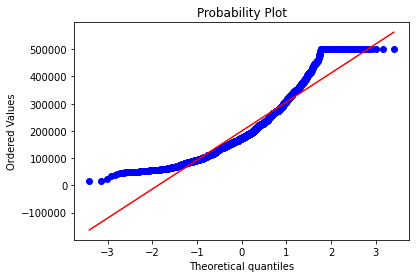

In [20]:
fig = plt.figure()
ax = fig.add_subplot()
res = stats.probplot(pd_df_housing['median_house_value'], plot=plt)

График показывает, что выборочные данные распределены неравномерно, что может сказаться на качестве предсказания. Посмотрим на распределение таргета.

Text(0.5, 1.0, 'median_house_value distribution')

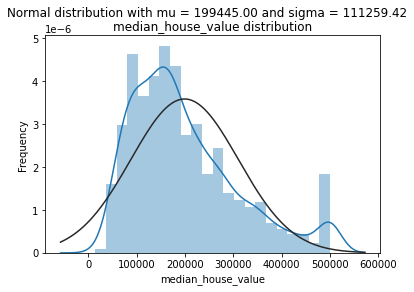

In [21]:
sns.distplot(pd_df_housing['median_house_value'], fit=norm);

# parameters
(mu, sigma) = norm.fit(pd_df_housing['median_house_value'])

plt.suptitle('Normal distribution with mu = {:.2f} and sigma = {:.2f}'.format(mu, sigma))
plt.ylabel('Frequency')
plt.title('median_house_value distribution')


График показывает, что большиноство объектов имеет медианную стоимость от 100000 до 250000, однако имеется пик на стоимости 500000. Как уже отмечалось, распределение далеко от нормального.

Посмотрим парную корреляцию столбцов относительно таргета median_house_value, Т.к распределение признака не соответствует нормальному распределению, применим коэффициент ранговой корреляции Кендалла (еще говорят тау Кендалла или тау-коэффициент, Kendall’s rank correlation coefficient), как и метод Спирмена, может применяться для измерения силы взаимосвязи количественных и порядковых категориальных переменных и подходит для анализа нелинейных зависимостей. Это также непараметрический тест.

In [22]:
corr = pd_df_housing.corr(method='kendall')

In [23]:
corr[['median_house_value']].sort_values(by='median_house_value',ascending=False).style.background_gradient(cmap='viridis', axis=None)

,median_house_value
median_house_value,1.000000
median_income,0.498126
total_rooms,0.129726
households,0.065127
total_bedrooms,0.049406
housing_median_age,0.044868
population,-0.002182
longitude,-0.036173
latitude,-0.129465


Наибольшая зависимость таргета выявлена с признаком  median_income.

## Описание категориальных параметров

<AxesSubplot:title={'center':'violinplot: median_house_value ratio with ocean_proximity'}, xlabel='ocean_proximity', ylabel='median_house_value'>

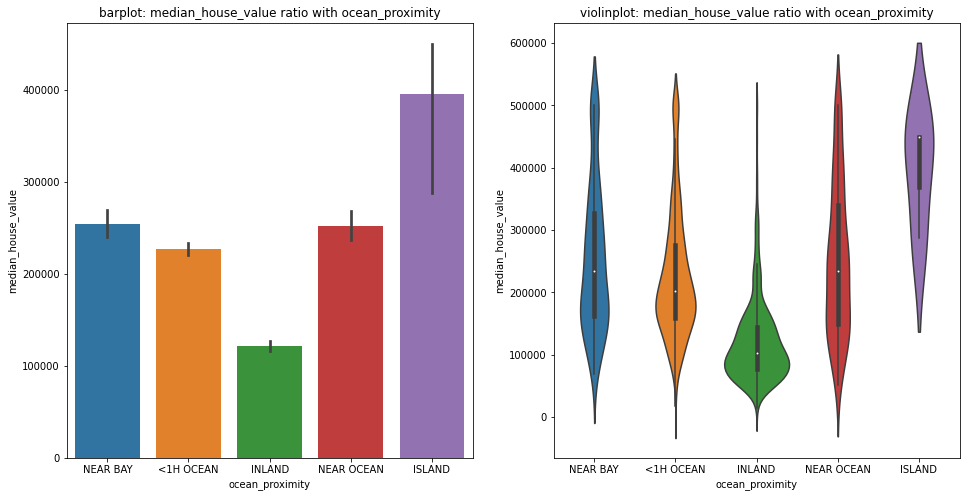

In [24]:
fig, ax = plt.subplots(1,2, figsize=(16,8))
ax[0].set_title('barplot: median_house_value ratio with ocean_proximity')
sns.barplot(x= pd_df_housing['ocean_proximity'], y=pd_df_housing['median_house_value'],ax=ax[0])

ax[1].set_title('violinplot: median_house_value ratio with ocean_proximity')
sns.violinplot(pd_df_housing['ocean_proximity'],pd_df_housing['median_house_value'], ax=ax[1])

<AxesSubplot:title={'center':'violinplot: median_income ratio with ocean_proximity'}, xlabel='ocean_proximity', ylabel='median_income'>

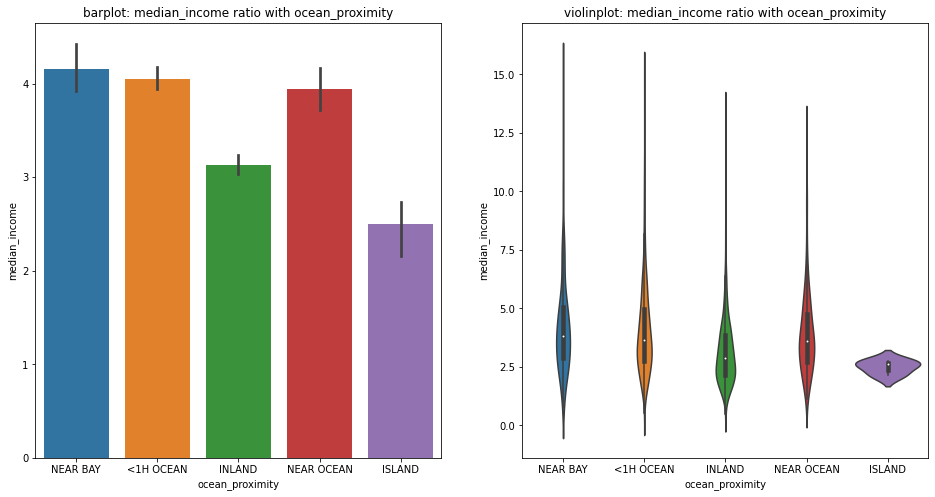

In [25]:

fig, ax = plt.subplots(1,2, figsize=(16,8))
ax[0].set_title('barplot: median_income ratio with ocean_proximity')
sns.barplot(x= pd_df_housing['ocean_proximity'], y=pd_df_housing['median_income'],ax=ax[0])

ax[1].set_title('violinplot: median_income ratio with ocean_proximity')
sns.violinplot(pd_df_housing['ocean_proximity'],pd_df_housing['median_income'], ax=ax[1])


<AxesSubplot:title={'center':'violinplot: total_rooms ratio with ocean_proximity'}, xlabel='ocean_proximity', ylabel='total_rooms'>

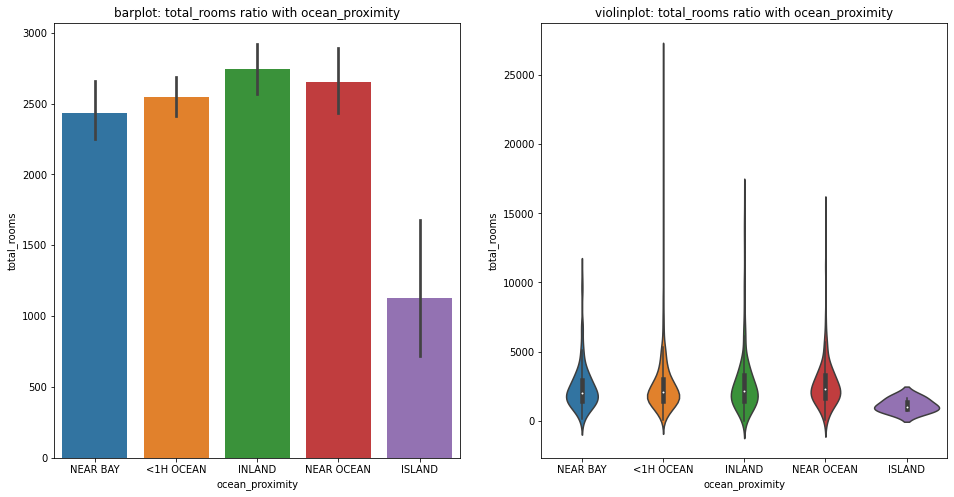

In [26]:
fig, ax = plt.subplots(1,2, figsize=(16,8))
ax[0].set_title('barplot: total_rooms ratio with ocean_proximity')
sns.barplot(x= pd_df_housing['ocean_proximity'], y=pd_df_housing['total_rooms'],ax=ax[0])

ax[1].set_title('violinplot: total_rooms ratio with ocean_proximity')
sns.violinplot(pd_df_housing['ocean_proximity'],pd_df_housing['total_rooms'], ax=ax[1])

<AxesSubplot:title={'center':'violinplot: total_bedrooms ratio with ocean_proximity'}, xlabel='ocean_proximity', ylabel='total_bedrooms'>

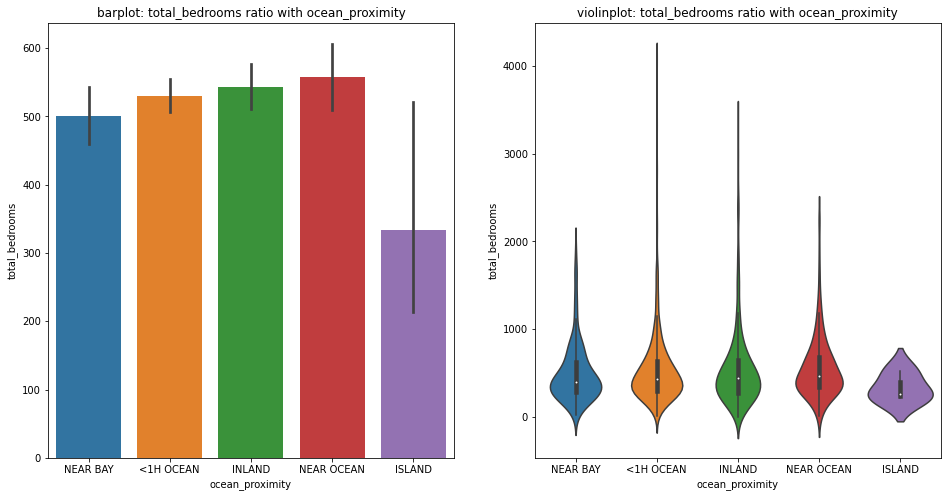

In [27]:
fig, ax = plt.subplots(1,2, figsize=(16,8))
ax[0].set_title('barplot: total_bedrooms ratio with ocean_proximity')
sns.barplot(x= pd_df_housing['ocean_proximity'], y=pd_df_housing['total_bedrooms'],ax=ax[0])

ax[1].set_title('violinplot: total_bedrooms ratio with ocean_proximity')
sns.violinplot(pd_df_housing['ocean_proximity'],pd_df_housing['total_bedrooms'], ax=ax[1])

<AxesSubplot:title={'center':'violinplot: housing_median_age ratio with ocean_proximity'}, xlabel='ocean_proximity', ylabel='housing_median_age'>

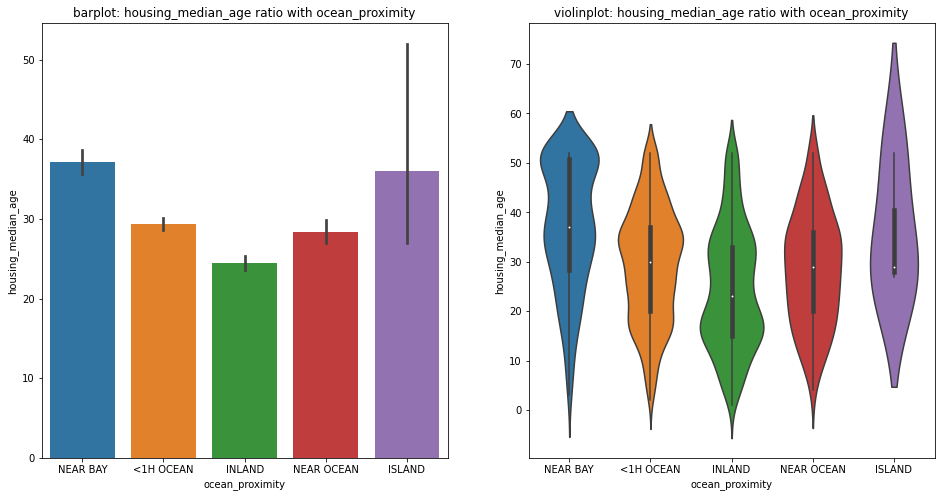

In [28]:
fig, ax = plt.subplots(1,2, figsize=(16,8))
ax[0].set_title('barplot: housing_median_age ratio with ocean_proximity')
sns.barplot(x= pd_df_housing['ocean_proximity'], y=pd_df_housing['housing_median_age'],ax=ax[0])

ax[1].set_title('violinplot: housing_median_age ratio with ocean_proximity')
sns.violinplot(pd_df_housing['ocean_proximity'],pd_df_housing['housing_median_age'], ax=ax[1])

<AxesSubplot:title={'center':'violinplot: households ratio with ocean_proximity'}, xlabel='ocean_proximity', ylabel='households'>

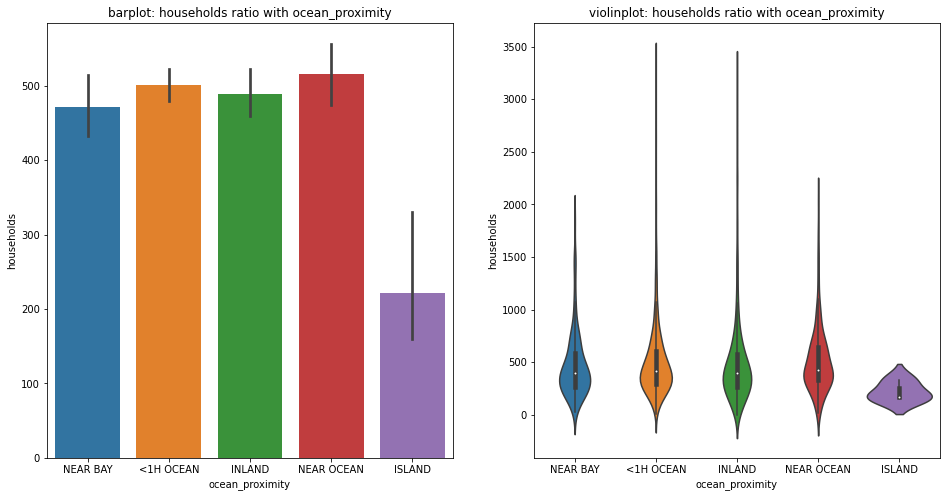

In [29]:
fig, ax = plt.subplots(1,2, figsize=(16,8))
ax[0].set_title('barplot: households ratio with ocean_proximity')
sns.barplot(x= pd_df_housing['ocean_proximity'], y=pd_df_housing['households'],ax=ax[0])

ax[1].set_title('violinplot: households ratio with ocean_proximity')
sns.violinplot(pd_df_housing['ocean_proximity'],pd_df_housing['households'], ax=ax[1])

<AxesSubplot:title={'center':'violinplot: total_bedrooms ratio with ocean_proximity'}, xlabel='ocean_proximity', ylabel='total_bedrooms'>

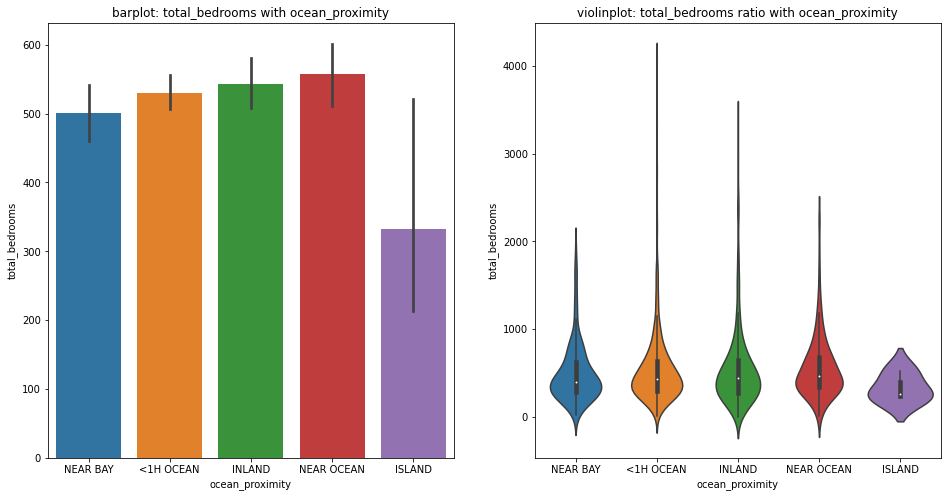

In [30]:
fig, ax = plt.subplots(1,2, figsize=(16,8))
ax[0].set_title('barplot: total_bedrooms with ocean_proximity')
sns.barplot(x= pd_df_housing['ocean_proximity'], y=pd_df_housing['total_bedrooms'],ax=ax[0])

ax[1].set_title('violinplot: total_bedrooms ratio with ocean_proximity')
sns.violinplot(pd_df_housing['ocean_proximity'],pd_df_housing['total_bedrooms'], ax=ax[1])

<AxesSubplot:title={'center':'violinplot: population ratio with ocean_proximity'}, xlabel='ocean_proximity', ylabel='population'>

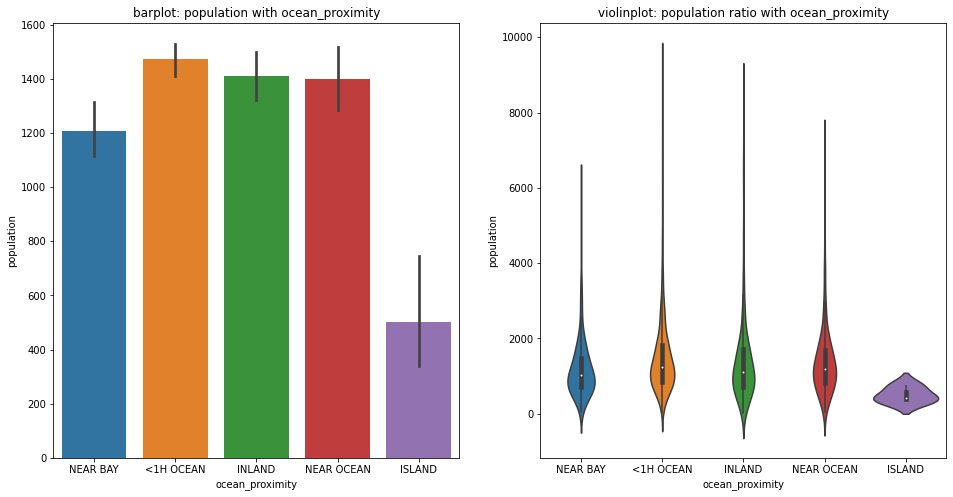

In [31]:
fig, ax = plt.subplots(1,2, figsize=(16,8))
ax[0].set_title('barplot: population with ocean_proximity')
sns.barplot(x= pd_df_housing['ocean_proximity'], y=pd_df_housing['population'],ax=ax[0])

ax[1].set_title('violinplot: population ratio with ocean_proximity')
sns.violinplot(pd_df_housing['ocean_proximity'],pd_df_housing['population'], ax=ax[1])

<AxesSubplot:title={'center':'violinplot: longitude ratio with ocean_proximity'}, xlabel='ocean_proximity', ylabel='longitude'>

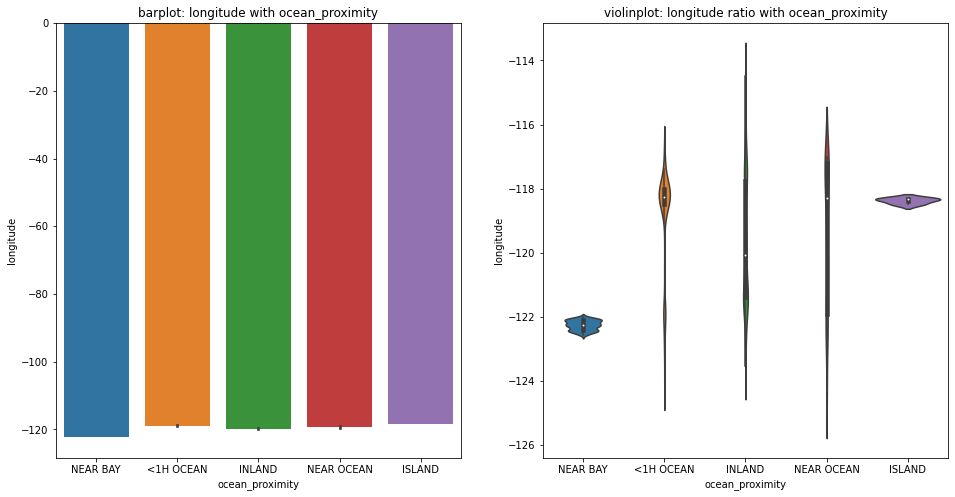

In [32]:
fig, ax = plt.subplots(1,2, figsize=(16,8))
ax[0].set_title('barplot: longitude with ocean_proximity')
sns.barplot(x= pd_df_housing['ocean_proximity'], y=pd_df_housing['longitude'],ax=ax[0])

ax[1].set_title('violinplot: longitude ratio with ocean_proximity')
sns.violinplot(pd_df_housing['ocean_proximity'],pd_df_housing['longitude'], ax=ax[1])

<AxesSubplot:title={'center':'violinplot: latitude ratio with ocean_proximity'}, xlabel='ocean_proximity', ylabel='latitude'>

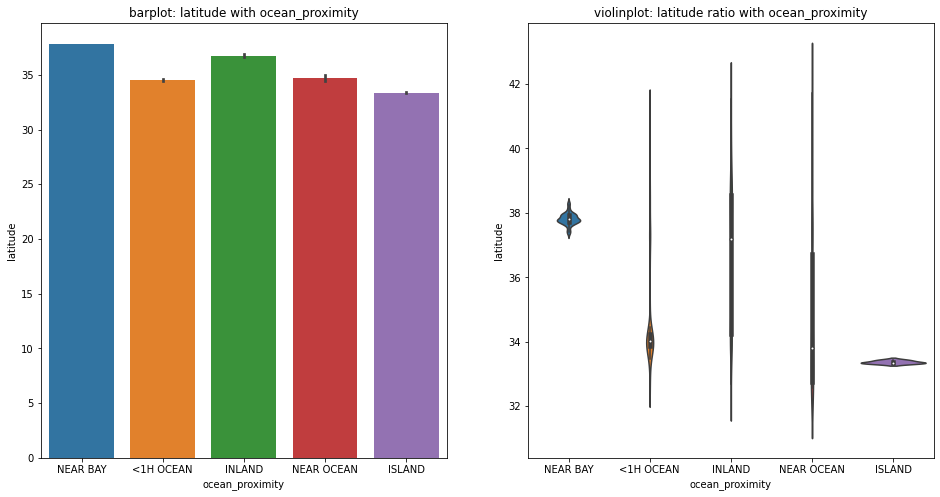

In [33]:
fig, ax = plt.subplots(1,2, figsize=(16,8))
ax[0].set_title('barplot: latitude with ocean_proximity')
sns.barplot(x= pd_df_housing['ocean_proximity'], y=pd_df_housing['latitude'],ax=ax[0])

ax[1].set_title('violinplot: latitude ratio with ocean_proximity')
sns.violinplot(pd_df_housing['ocean_proximity'],pd_df_housing['latitude'], ax=ax[1])

Вывод: Изучив предоставленные графики, мы можем сделать следующие выводы:

median_house_value: наибольшую стоимость имеет жилье расположенное в 1H OCEAN 
median_income: наибольший доход имеют жители массивов, расположенных в 1H OCEAN и NEAR BAY.
total_rooms: наибольшее количество комнат в жилых массивах, расположенных в  1H OCEAN и INLAND, наименьшее в ISLAND.
total_bedrooms: наибольшее количество комнат в жилых массивах, расположенных в  1H OCEAN и NEAR BAY, наименьшее в ISLAND.
housing_median_age: в ISLAND живут наиболее возрастные жильцы, а в INLAND самые молодые.
households: Наибольшее количество домовладений расположено в NEAR OCEAN и 1H OCEAN, наименьшее в ISLAND.
population: наибольшее количество челрвек в жилом массиве наблюдается в 1H OCEAN, наименьшее в ISLAND.
Все домовладения расположены на широте от -120 до -114, долготе от 32 до 45

## Описание количественных параметров

Для описания количественных параметров выведем их гистограммы и их статистики в абсолютных и нормализированных величинах.

In [34]:
num_cols = [col for col in pd_df_housing.columns if pd_df_housing[col].dtype != 'object']

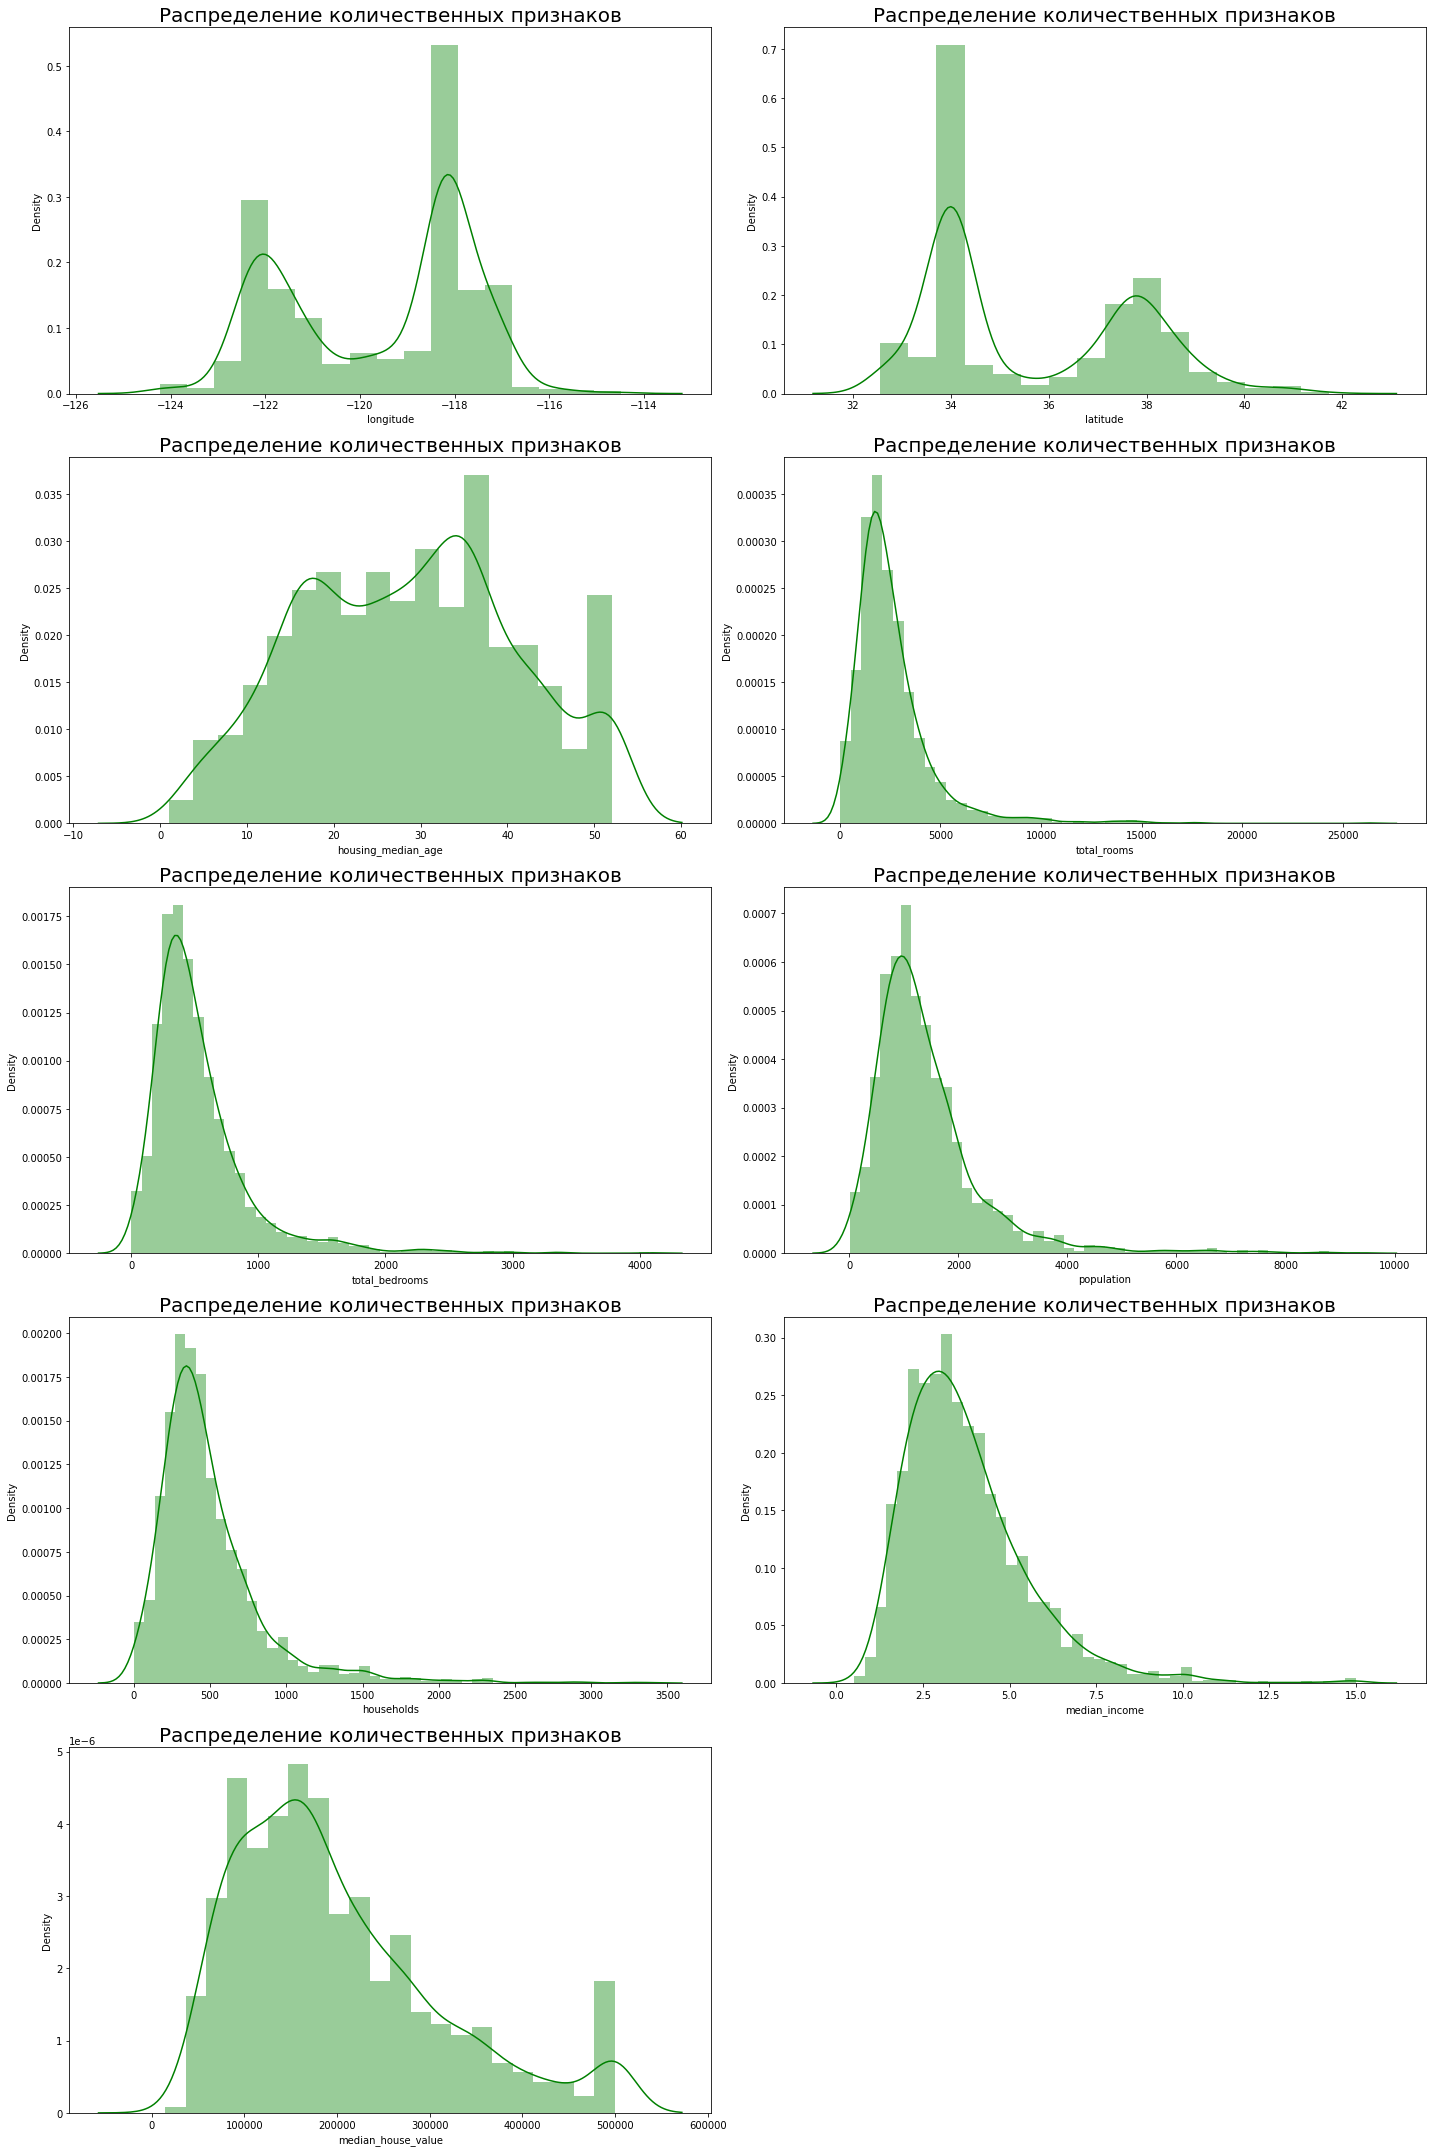

In [35]:
plt.figure(figsize = (20, 30))
plotnumber = 1
for column in num_cols:
    if plotnumber <= 20:
        ax = plt.subplot(5, 2, plotnumber)
        sns.distplot(pd_df_housing[column],color='green',)
        plt.title('Распределение количественных признаков', size = 20)
        plt.xlabel(column)
    
        
    plotnumber += 1

plt.tight_layout()
plt.show()

Построим диаграммы рессеяния для количественных признаков

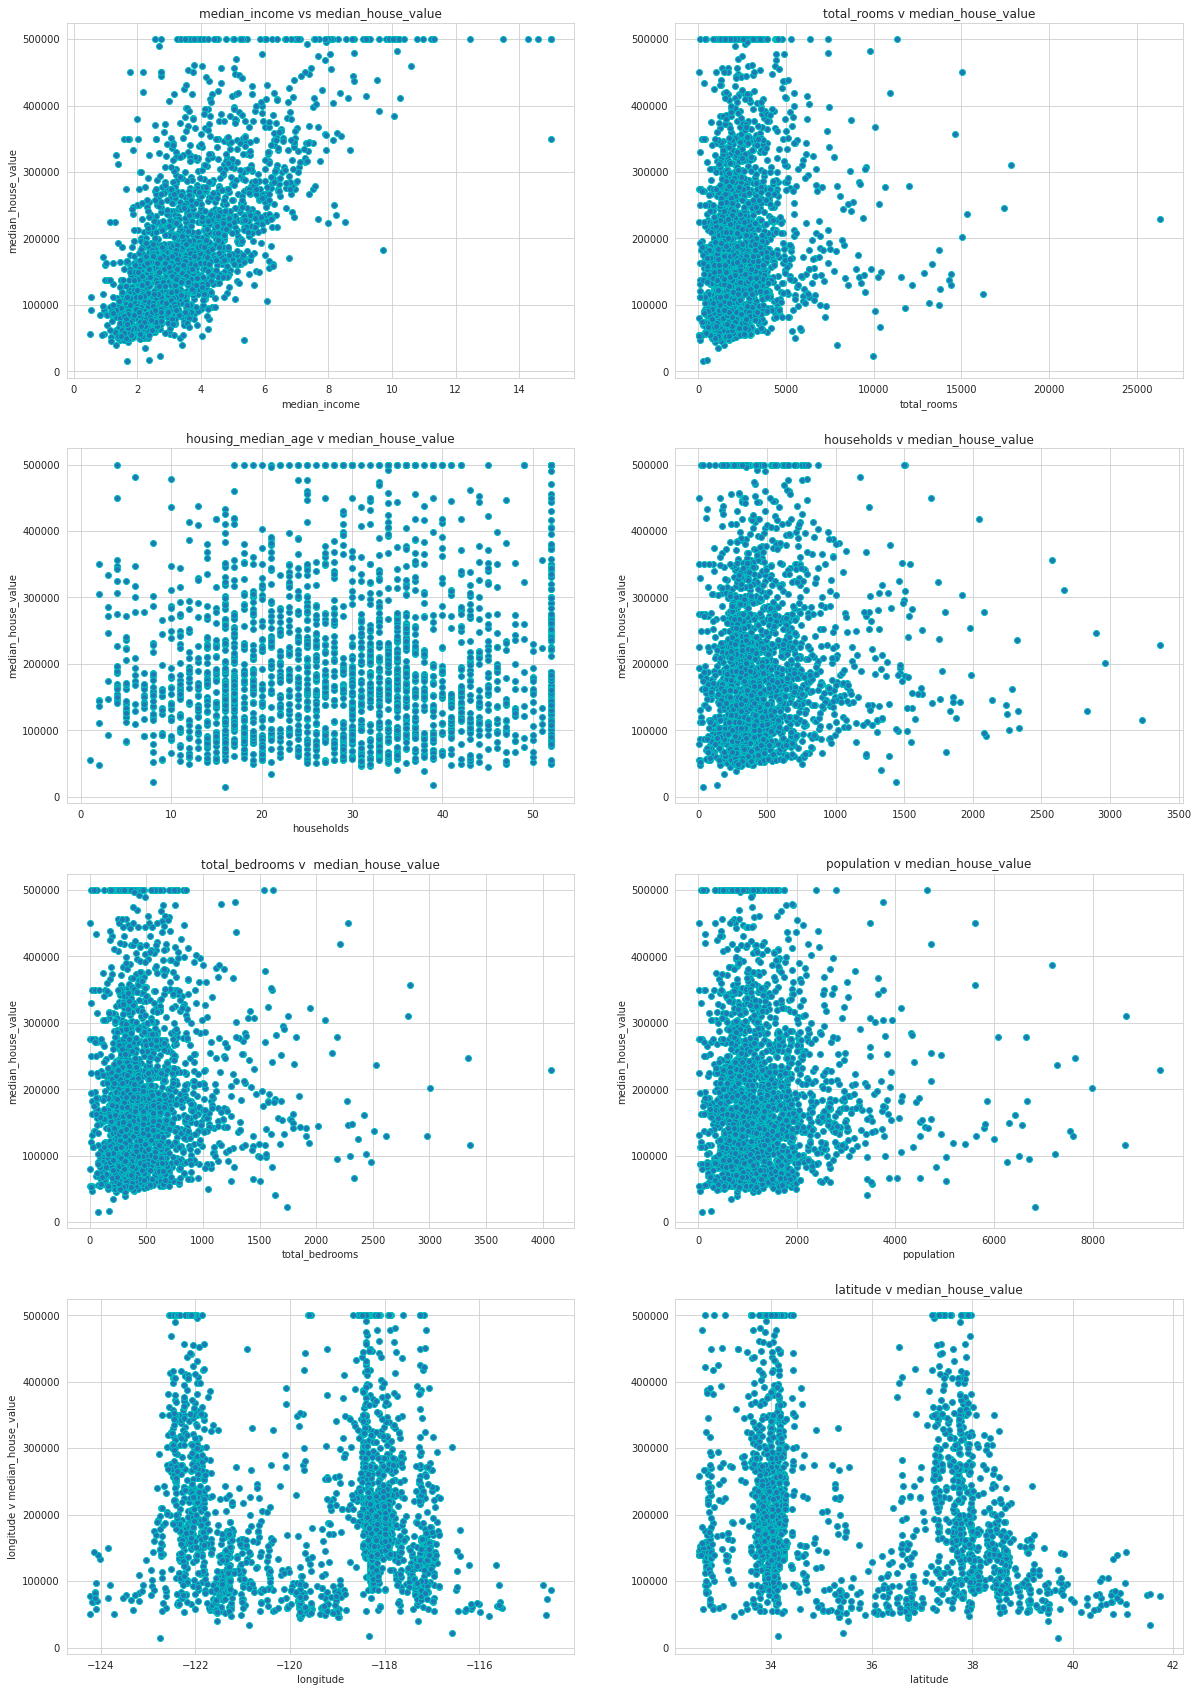

In [36]:
# Suplots of numeric features v price
sns.set_style('whitegrid')
f, axes = plt.subplots(4,2, figsize = (20,30))

# Plot [0,0]
axes[0,0].scatter(x = 'median_income', y = 'median_house_value', data = pd_df_housing, edgecolor='c')
axes[0,0].set_xlabel('median_income')
axes[0,0].set_ylabel('median_house_value')
axes[0,0].set_title('median_income vs median_house_value')

# Plot [0,1]
axes[0,1].scatter(x = 'total_rooms', y = 'median_house_value', data = pd_df_housing, edgecolor = 'c')
axes[0,1].set_xlabel('total_rooms')
# axes[0,1].set_ylabel('Price')
axes[0,1].set_title('total_rooms v median_house_value')

# Plot [1,0]
axes[1,0].scatter(x = 'housing_median_age', y = 'median_house_value', data = pd_df_housing, edgecolor = 'c')
axes[1,0].set_xlabel('housing_median_age')
axes[1,0].set_ylabel('median_house_value')
axes[1,0].set_title('housing_median_age v median_house_value')

# Plot [1,1]
axes[1,1].scatter(x = 'households', y = 'median_house_value', data = pd_df_housing, edgecolor = 'c')
axes[1,0].set_xlabel('households')
axes[1,1].set_ylabel('median_house_value')
axes[1,1].set_title('households v median_house_value')

# Plot [2,0]
axes[2,0].scatter(x = 'total_bedrooms', y = 'median_house_value', data = pd_df_housing, edgecolor = 'c')
axes[2,0].set_xlabel('total_bedrooms')
axes[2,0].set_ylabel('median_house_value')
axes[2,0].set_title('total_bedrooms v  median_house_value')

# Plot [2,1c
axes[2,1].scatter(x = 'population', y = 'median_house_value', data = pd_df_housing, edgecolor = 'c')
axes[2,1].set_xlabel('population')
axes[2,1].set_ylabel('median_house_value')
axes[2,1].set_title('population v median_house_value')

# Plot [3,0]
axes[3,0].scatter(x = 'longitude', y = 'median_house_value', data = pd_df_housing, edgecolor = 'c')
axes[3,0].set_xlabel('longitude')
axes[3,0].set_ylabel('median_house_value')
axes[3,0].set_ylabel('longitude v median_house_value')

# Plot [3,1]
axes[3,1].scatter(x = 'latitude', y = 'median_house_value', data = pd_df_housing, edgecolor = 'c')
axes[3,1].set_xlabel('latitude')
#axes[3,1].set_ylabel('median_house_value')
axes[3,1].set_title('latitude v median_house_value')

plt.show()


##### Вывод:

На основе гистограмм и статистических данных по количественным признакам можно сделать следующие заключения:

median_income:распределение приближено к нормальному, наибольшее количество собственников имеют доход от 2 до 4,5.
total_rooms: распределение приближено к нормальному, наибольшее количество массивов имеет количество комнат от 2000 до 4000.
housing_median_age: наибольшее количество собственников жилья имеет возраст от 15 до 38 лет.
households: наибольшее количество жилых массивов имет от 2500 до 7000 домовладений.
population:наибольшее количество жилых массивов имеет от 2500 до 4000 проживающих
total_bedrooms: наибольшее количество жилых массивов имеет количество спален  от 500 до 1500.

Графики зависимости от таргета показывают: наличие прямой зависимости таргета от уровня дохода владельцев жилья.

# Корреляционный анализ

#### Корреляционный анализ для предсказания median_house_value
Проведем корреляционный анализ. Так как в данных присутствуют категориальные значения, для построения матрицы корреляции будем использовать библиотеку phik

In [37]:
# Проведем корреляционный анализ с использованием библиотеки phik
#df_job_drop_id = df_job.drop('id', axis=1)
corr_matrix_df = pd_df_housing.phik_matrix(interval_cols=['median_house_value', 'median_income','total_rooms','housing_median_age','households','total_bedrooms','population','longitude','latitude'])
corr_matrix_df.round(2)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
longitude,1.00,0.90,0.39,0.00,0.00,0.12,0.00,0.25,0.49,0.77
latitude,0.90,1.00,0.33,0.07,0.07,0.15,0.08,0.26,0.52,0.82
housing_median_age,0.39,0.33,1.00,0.35,0.43,0.38,0.38,0.23,0.22,0.40
total_rooms,0.00,0.07,0.35,1.00,0.89,0.82,0.85,0.16,0.12,0.02
total_bedrooms,0.00,0.07,0.43,0.89,1.00,0.92,0.97,0.08,0.12,0.00
population,0.12,0.15,0.38,0.82,0.92,1.00,0.95,0.05,0.14,0.14
households,0.00,0.08,0.38,0.85,0.97,0.95,1.00,0.14,0.12,0.06
median_income,0.25,0.26,0.23,0.16,0.08,0.05,0.14,1.00,0.73,0.26
median_house_value,0.49,0.52,0.22,0.12,0.12,0.14,0.12,0.73,1.00,0.63
ocean_proximity,0.77,0.82,0.40,0.02,0.00,0.14,0.06,0.26,0.63,1.00


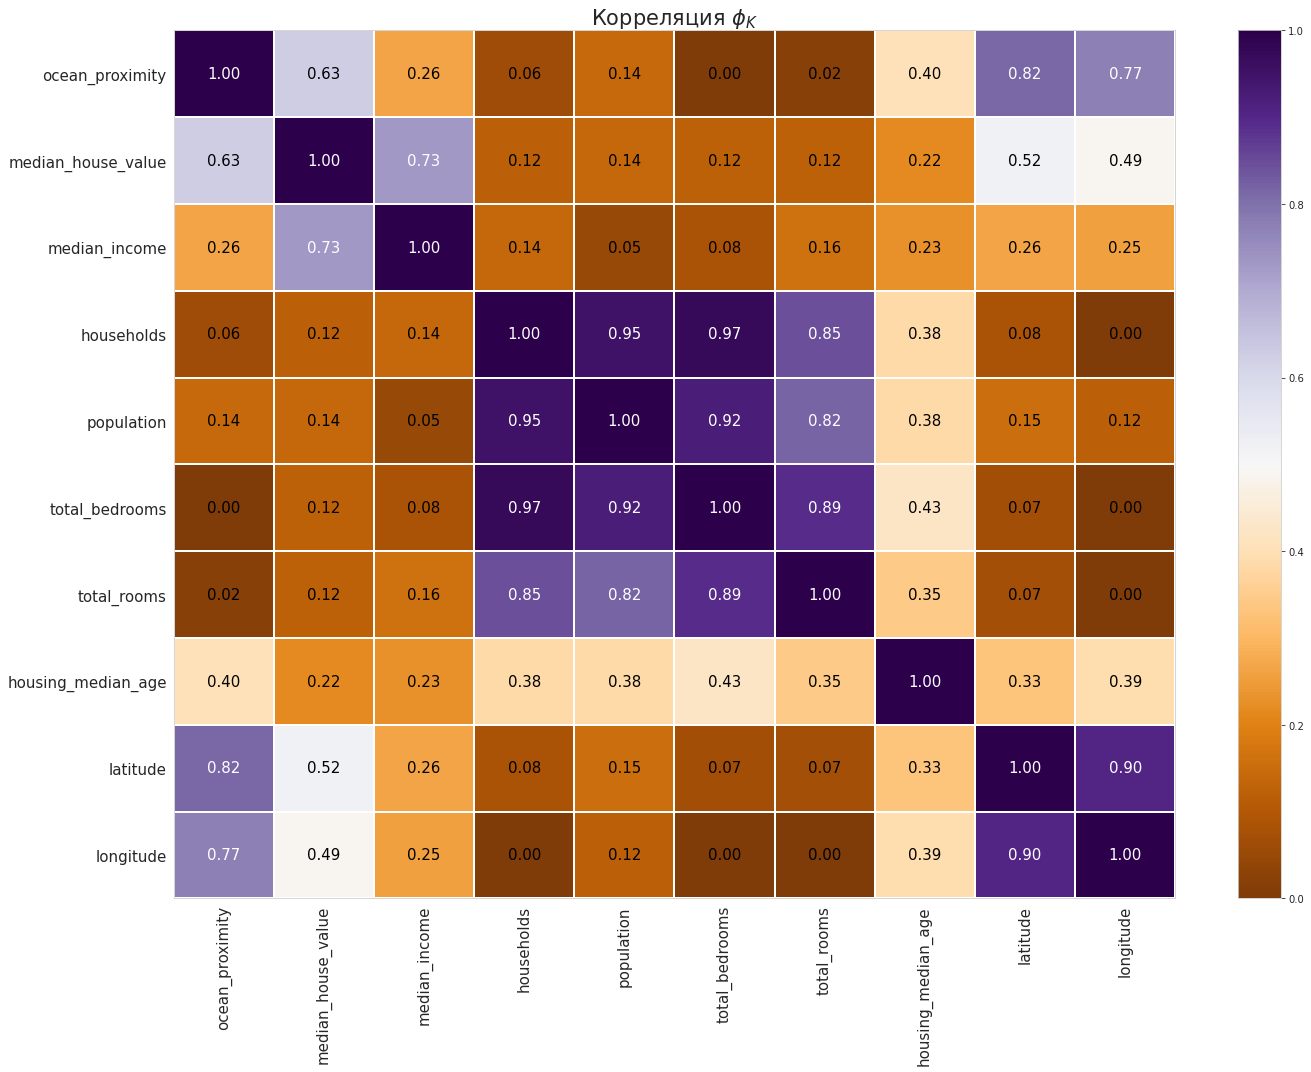

In [38]:
plot_correlation_matrix(
    corr_matrix_df.values,
    x_labels=corr_matrix_df.columns,
    y_labels=corr_matrix_df.index,
    vmin=0, vmax=1, color_map='PuOr', 
    title=r'Корреляция $\phi_K$',  
    fontsize_factor=1.5,  
    figsize=(20, 15)
)

In [39]:
chaddock_scale(pd_df_housing, phik=True);

interval columns not set, guessing: ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']

Для столбцов 'total_bedrooms' и 'households':
Коэффициент корреляции: 0.974
Теснота связи: Весьма высокая
Тип связи: Прямая связь

Для столбцов 'population' и 'households':
Коэффициент корреляции: 0.953
Теснота связи: Весьма высокая
Тип связи: Прямая связь

Для столбцов 'total_bedrooms' и 'population':
Коэффициент корреляции: 0.922
Теснота связи: Весьма высокая
Тип связи: Прямая связь

Для столбцов 'longitude' и 'latitude':
Коэффициент корреляции: 0.903
Теснота связи: Весьма высокая
Тип связи: Прямая связь

Для столбцов 'total_rooms' и 'total_bedrooms':
Коэффициент корреляции: 0.893
Теснота связи: Высокая
Тип связи: Прямая связь

Для столбцов 'total_rooms' и 'households':
Коэффициент корреляции: 0.848
Теснота связи: Высокая
Тип связи: Прямая связь

Для столбцов 'total_rooms' и 'population':
Коэффициент к

##### Вывод:

###### Уровень  корреляции для 'median_income' и 'median_house_value': 
Существует высокая положительная корреляция (0.733), что может означать, что высокий доход позволяет владеть более дорогой недвижимостью.

###### Уровень  корреляции для ''latitude' и 'longitude' и 'median_house_value':
Между этими параметрами также наблюдается заметная положительная корреляция (0.523 и 0,516), что указывает на то, что стоимость жилья напрямую зависит от географического положения (долготы и широты).


После использования выборки необходимо освободить память с помощью unpersist(), чтобы освободить ресурсы.

In [40]:
# Освобождение памяти после использования выборки
pd_df_housing_s.unpersist()

DataFrame[longitude: double, latitude: double, housing_median_age: double, total_rooms: double, total_bedrooms: double, population: double, households: double, median_income: double, median_house_value: double, ocean_proximity: string]

## Разделение данных на выборки

По условиям задачи нам необходимо сформировать еще один датафрейм без категориальных данных. Сформируем его

In [41]:
df_num = df_housing.drop('ocean_proximity')
df_num 

DataFrame[longitude: double, latitude: double, housing_median_age: double, total_rooms: double, total_bedrooms: double, population: double, households: double, median_income: double, median_house_value: double]

Разделим оба датафрейма на выборки

In [42]:
(train_df_all, test_df_all) = df_housing.randomSplit([.7,.3],seed=1234)
train_df_all, test_df_all

(DataFrame[longitude: double, latitude: double, housing_median_age: double, total_rooms: double, total_bedrooms: double, population: double, households: double, median_income: double, median_house_value: double, ocean_proximity: string],
 DataFrame[longitude: double, latitude: double, housing_median_age: double, total_rooms: double, total_bedrooms: double, population: double, households: double, median_income: double, median_house_value: double, ocean_proximity: string])

In [43]:
(train_df_numeric, test_df_numeric) = df_num.randomSplit([.7,.3],seed=RANDOM_SEED)
train_df_numeric, test_df_numeric

(DataFrame[longitude: double, latitude: double, housing_median_age: double, total_rooms: double, total_bedrooms: double, population: double, households: double, median_income: double, median_house_value: double],
 DataFrame[longitude: double, latitude: double, housing_median_age: double, total_rooms: double, total_bedrooms: double, population: double, households: double, median_income: double, median_house_value: double])

## Подготовка данных к обучению

Произведем подготовку данных: масштабируем числовые признаки, кодируем категориальные признаки отдельно в каждом датафрейме.

In [44]:
numerical_features_lst = train_df_all.columns
numerical_features_lst.remove('median_house_value')
numerical_features_lst.remove('ocean_proximity')

numerical_features_lst

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income']

In [45]:
numerical_features_num = train_df_numeric.columns
numerical_features_num.remove('median_house_value')

numerical_features_num

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income']

Трансформация числовых признаков

При проведении трансформации произведем заполнение пропусков средним значением "mean" с помощью метода setStrategy() в обеих выборках.

In [46]:
imputer = Imputer(inputCols=numerical_features_lst,
                  outputCols=numerical_features_lst).setStrategy("mean")

imputer = imputer.fit(train_df_all)

train_df_all = imputer.transform(train_df_all)
test_df_all = imputer.transform(test_df_all)

train_df_all.show(3)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|   -124.3|   41.84|              17.0|     2677.0|         531.0|    1244.0|     456.0|       3.0313|          103600.0|     NEAR OCEAN|
|  -124.27|   40.69|              36.0|     2349.0|         528.0|    1194.0|     465.0|       2.5179|           79000.0|     NEAR OCEAN|
|  -124.25|   40.28|              32.0|     1430.0|         419.0|     434.0|     187.0|       1.9417|           76100.0|     NEAR OCEAN|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
only showing top 3 rows



In [47]:
imputer_2 = Imputer(inputCols=numerical_features_num,
                  outputCols=numerical_features_num).setStrategy("mean")

imputer_2 = imputer_2.fit(train_df_numeric)

train_df_numeric = imputer.transform(train_df_numeric)
test_df_numeric = imputer.transform(test_df_numeric)

train_df_numeric.show(3)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+
|  -124.35|   40.54|              52.0|     1820.0|         300.0|     806.0|     270.0|       3.0147|           94600.0|
|  -124.27|   40.69|              36.0|     2349.0|         528.0|    1194.0|     465.0|       2.5179|           79000.0|
|  -124.26|   40.58|              52.0|     2217.0|         394.0|     907.0|     369.0|       2.3571|          111400.0|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+
only showing top 3 rows



In [48]:
numerical_vector_assembler = VectorAssembler(inputCols=numerical_features_lst,
                                             outputCol='numerical_feature_vector')

train_df_all = numerical_vector_assembler.transform(train_df_all)
test_df_all = numerical_vector_assembler.transform(test_df_all)

train_df_all.show(2)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+------------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|numerical_feature_vector|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+------------------------+
|   -124.3|   41.84|              17.0|     2677.0|         531.0|    1244.0|     456.0|       3.0313|          103600.0|     NEAR OCEAN|    [-124.3,41.84,17....|
|  -124.27|   40.69|              36.0|     2349.0|         528.0|    1194.0|     465.0|       2.5179|           79000.0|     NEAR OCEAN|    [-124.27,40.69,36...|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+------------------------+
only showing top 2 row

In [49]:
numerical_vector_assembler_2 = VectorAssembler(inputCols=numerical_features_num,
                                             outputCol='numerical_feature_vector_2')

train_df_numeric = numerical_vector_assembler_2.transform(train_df_numeric)
test_df_numeric = numerical_vector_assembler_2.transform(test_df_numeric)

train_df_numeric.show(2)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+--------------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|numerical_feature_vector_2|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+--------------------------+
|  -124.35|   40.54|              52.0|     1820.0|         300.0|     806.0|     270.0|       3.0147|           94600.0|      [-124.35,40.54,52...|
|  -124.27|   40.69|              36.0|     2349.0|         528.0|    1194.0|     465.0|       2.5179|           79000.0|      [-124.27,40.69,36...|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+--------------------------+
only showing top 2 rows



In [50]:
train_df_all.select('numerical_feature_vector').take(2)

[Row(numerical_feature_vector=DenseVector([-124.3, 41.84, 17.0, 2677.0, 531.0, 1244.0, 456.0, 3.0313])),
 Row(numerical_feature_vector=DenseVector([-124.27, 40.69, 36.0, 2349.0, 528.0, 1194.0, 465.0, 2.5179]))]

In [51]:
train_df_numeric.select('numerical_feature_vector_2').take(2)

[Row(numerical_feature_vector_2=DenseVector([-124.35, 40.54, 52.0, 1820.0, 300.0, 806.0, 270.0, 3.0147])),
 Row(numerical_feature_vector_2=DenseVector([-124.27, 40.69, 36.0, 2349.0, 528.0, 1194.0, 465.0, 2.5179]))]

In [52]:
scaler = StandardScaler(inputCol='numerical_feature_vector',
                        outputCol='scaled_numerical_feature_vector',
                        withStd=True, withMean=True)

scaler = scaler.fit(train_df_all)

train_df_all = scaler.transform(train_df_all)
test_df_all = scaler.transform(test_df_all)

train_df_all.show(3)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+------------------------+-------------------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|numerical_feature_vector|scaled_numerical_feature_vector|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+------------------------+-------------------------------+
|   -124.3|   41.84|              17.0|     2677.0|         531.0|    1244.0|     456.0|       3.0313|          103600.0|     NEAR OCEAN|    [-124.3,41.84,17....|           [-2.3519381176774...|
|  -124.27|   40.69|              36.0|     2349.0|         528.0|    1194.0|     465.0|       2.5179|           79000.0|     NEAR OCEAN|    [-124.27,40.69,36...|           [-2.3369806173979...|
|  -124.25|   40.28|     

In [53]:
scaler_2 = StandardScaler(inputCol='numerical_feature_vector_2',
                        outputCol='scaled_numerical_feature_vector_2',
                        withStd=True, withMean=True)

scaler_2 = scaler_2.fit(train_df_numeric)

train_df_numeric = scaler_2.transform(train_df_numeric)
test_df_numeric = scaler_2.transform(test_df_numeric)

train_df_numeric.show(3)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+--------------------------+---------------------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|numerical_feature_vector_2|scaled_numerical_feature_vector_2|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+--------------------------+---------------------------------+
|  -124.35|   40.54|              52.0|     1820.0|         300.0|     806.0|     270.0|       3.0147|           94600.0|      [-124.35,40.54,52...|             [-2.3933700738809...|
|  -124.27|   40.69|              36.0|     2349.0|         528.0|    1194.0|     465.0|       2.5179|           79000.0|      [-124.27,40.69,36...|             [-2.3533972728693...|
|  -124.26|   40.58|              52.0|     2217.0|         394.0|     907.0|     369

In [54]:
train_df_all.select('scaled_numerical_feature_vector').take(3)

[Row(scaled_numerical_feature_vector=DenseVector([-2.3519, 2.9149, -0.9272, 0.0202, -0.0151, -0.1581, -0.1137, -0.4417])),
 Row(scaled_numerical_feature_vector=DenseVector([-2.337, 2.3746, 0.5805, -0.1303, -0.0223, -0.2017, -0.0901, -0.7089])),
 Row(scaled_numerical_feature_vector=DenseVector([-2.327, 2.1819, 0.2631, -0.552, -0.2833, -0.8653, -0.8193, -1.0087]))]

In [55]:
train_df_numeric.select('scaled_numerical_feature_vector_2').take(3)

[Row(scaled_numerical_feature_vector_2=DenseVector([-2.3934, 2.3053, 1.8524, -0.3703, -0.5651, -0.5377, -0.5971, -0.4495])),
 Row(scaled_numerical_feature_vector_2=DenseVector([-2.3534, 2.3757, 0.5795, -0.1311, -0.0222, -0.2005, -0.0892, -0.7118])),
 Row(scaled_numerical_feature_vector_2=DenseVector([-2.3484, 2.3241, 1.8524, -0.1908, -0.3412, -0.45, -0.3392, -0.7967]))]

Трансформация категорийных признаков

In [56]:
indexer = StringIndexer(inputCol='ocean_proximity',
                        outputCol='ocean_category_index')

indexer = indexer.fit(train_df_all)
train_df_all = indexer.transform(train_df_all)
test_df_all = indexer.transform(test_df_all)

train_df_all.show(3)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+------------------------+-------------------------------+--------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|numerical_feature_vector|scaled_numerical_feature_vector|ocean_category_index|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+------------------------+-------------------------------+--------------------+
|   -124.3|   41.84|              17.0|     2677.0|         531.0|    1244.0|     456.0|       3.0313|          103600.0|     NEAR OCEAN|    [-124.3,41.84,17....|           [-2.3519381176774...|                 2.0|
|  -124.27|   40.69|              36.0|     2349.0|         528.0|    1194.0|     465.0|       2.5179|           79000.0|     NEAR OCEAN

In [57]:
one_hot_encoder = OneHotEncoder(inputCol='ocean_category_index',
                                outputCol='ocean_category_one_hot')

one_hot_encoder = one_hot_encoder.fit(train_df_all)

train_df_all = one_hot_encoder.transform(train_df_all)
test_df_all = one_hot_encoder.transform(test_df_all)

train_df_all.show(3)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+------------------------+-------------------------------+--------------------+----------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|numerical_feature_vector|scaled_numerical_feature_vector|ocean_category_index|ocean_category_one_hot|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+------------------------+-------------------------------+--------------------+----------------------+
|   -124.3|   41.84|              17.0|     2677.0|         531.0|    1244.0|     456.0|       3.0313|          103600.0|     NEAR OCEAN|    [-124.3,41.84,17....|           [-2.3519381176774...|                 2.0|         (4,[2],[1.0])|
|  -124.27|   40.69|              36.0|     

Финальный шаг преобразований — это объединение признаков в один вектор, с которым ML-алгоритм умеет работать.

In [58]:
assembler = VectorAssembler(inputCols=['scaled_numerical_feature_vector',
                                       'ocean_category_one_hot'],
                            outputCol='final_feature_vector')

train_df_all = assembler.transform(train_df_all)
test_df_all = assembler.transform(test_df_all)

In [59]:
assembler_numeric = VectorAssembler(inputCols=['scaled_numerical_feature_vector_2'],
                            outputCol='final_feature_vector_2')

train_df_numeric = assembler_numeric.transform(train_df_numeric)
test_df_numeric = assembler_numeric.transform(test_df_numeric)

In [60]:
train_df_all.select('final_feature_vector').take(2)

[Row(final_feature_vector=DenseVector([-2.3519, 2.9149, -0.9272, 0.0202, -0.0151, -0.1581, -0.1137, -0.4417, 0.0, 0.0, 1.0, 0.0])),
 Row(final_feature_vector=DenseVector([-2.337, 2.3746, 0.5805, -0.1303, -0.0223, -0.2017, -0.0901, -0.7089, 0.0, 0.0, 1.0, 0.0]))]

In [61]:
train_df_numeric.select('final_feature_vector_2').take(2)

[Row(final_feature_vector_2=DenseVector([-2.3934, 2.3053, 1.8524, -0.3703, -0.5651, -0.5377, -0.5971, -0.4495])),
 Row(final_feature_vector_2=DenseVector([-2.3534, 2.3757, 0.5795, -0.1311, -0.0222, -0.2005, -0.0892, -0.7118]))]

Создадим две модели. 

In [62]:
lr_all = LinearRegression(featuresCol='final_feature_vector',
                      labelCol='median_house_value', maxIter=10, 
                      regParam=0.8, elasticNetParam=0.1)

lr_all

LinearRegression_3f63ba9576e1

In [63]:
lr_numeric = LinearRegression(featuresCol='final_feature_vector_2',
                      labelCol='median_house_value', maxIter=10, 
                      regParam=0.8, elasticNetParam=0.1)

lr_numeric

LinearRegression_6991e289cbae

Подготовим pipeline для каждой модели

In [64]:
pipeline = Pipeline(stages=[lr_all])

In [65]:
pipeline_2 = Pipeline(stages=[lr_numeric])

In [66]:
paramGrid = ParamGridBuilder().addGrid(lr_all.regParam, [0.1, 0.01]).addGrid(lr_all.elasticNetParam, [0.0, 0.5]).build()

In [67]:
paramGrid_2 = ParamGridBuilder().addGrid(lr_numeric.regParam, [0.1, 0.01]).addGrid(lr_numeric.elasticNetParam, [0.0, 0.5]).build()

# Обучение моделей  

Обучим модели согласно условиям задачи.

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator().setLabelCol("median_house_value"),
                          numFolds=5)  # Количество складываний для кросс-валидации

# Обучение модели с использованием grid search
cvModel = crossval.fit(train_df_all)


24/06/27 11:05:46 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
24/06/27 11:05:46 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
24/06/27 11:05:47 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
24/06/27 11:05:47 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


In [ ]:

crossval_2 = CrossValidator(estimator=pipeline_2,
                          estimatorParamMaps=paramGrid_2,
                          evaluator=RegressionEvaluator().setLabelCol("median_house_value"),
                          numFolds=5)  # Количество складываний для кросс-валидации

# Обучение модели с использованием grid search
cvModel_2 = crossval_2.fit(train_df_numeric)


In [ ]:
pred_train_df = cvModel.transform(train_df_all).withColumnRenamed('prediction',
                                                      'predicted_median_house_value')

pred_train_df.show(5)

In [ ]:
pred_train_df_num = cvModel_2.transform(train_df_numeric).withColumnRenamed('prediction',
                                                      'predicted_median_house_value_2')

pred_train_df_num.show(5)

In [ ]:
pred_test_df = cvModel.transform(test_df_all).withColumnRenamed('prediction', 'predicted_median_house_value')

pred_test_df.show(5)

In [ ]:
pred_test_pd_df = pred_test_df.toPandas()

pred_test_pd_df.head(2)

In [ ]:
pred_test_df_num = cvModel_2.transform(test_df_numeric).withColumnRenamed('prediction', 'predicted_median_house_value_2')

pred_test_df_num.show(5)

# Анализ результатов

In [ ]:
predictions_and_actuals = pred_test_df[['predicted_median_house_value',
                                        'median_house_value']]
                                    
predictions_and_actuals_rdd = predictions_and_actuals.rdd

predictions_and_actuals_rdd

In [ ]:
predictions_and_actuals_num = pred_test_df_num[['predicted_median_house_value_2',
                                        'median_house_value']]
                                    
predictions_and_actuals_rdd_num = predictions_and_actuals_num.rdd

predictions_and_actuals_rdd_num

In [ ]:
predictions_and_actuals_rdd = predictions_and_actuals_rdd.map(tuple)

predictions_and_actuals_rdd.take(2)

In [ ]:
predictions_and_actuals_rdd_num = predictions_and_actuals_rdd_num.map(tuple)

predictions_and_actuals_rdd_num.take(2)

In [ ]:
from pyspark.mllib.evaluation import RegressionMetrics
metrics = RegressionMetrics(predictions_and_actuals_rdd)

s = '''
Mean Squared Error:      {0}
Root Mean Squared Error: {1}
Mean Absolute Error:     {2}
R**2:                    {3}
'''.format(metrics.meanSquaredError,
           metrics.rootMeanSquaredError,
           metrics.meanAbsoluteError,
           metrics.r2
           )

print(s)

In [ ]:
metrics_2 = RegressionMetrics(predictions_and_actuals_rdd_num)

s = '''
Mean Squared Error:      {0}
Root Mean Squared Error: {1}
Mean Absolute Error:     {2}
R**2:                    {3}
'''.format(metrics_2.meanSquaredError,
           metrics_2.rootMeanSquaredError,
           metrics_2.meanAbsoluteError,
           metrics_2.r2
           )

print(s)

Получим метрики с использованием обеих моделей. С помощью  ParamGridBuilder удалось улучшить метрики. Лучший результат показала модель, где использованлись только числовые параметры. Метрики: Mean Squared Error:4791727802.297069
Root Mean Squared Error: 69222.30711480996
Mean Absolute Error:     50933.79706115405
R**2:                    0.6398084592858735

# Итоговые выводы

## Описание задачи

В ходе проекта были рассмотрены задачи, связанные с предсказанием стоимости жилья в Калифорнии.

## Этапы работы

1. Предварительный анализ данных: На начальном этапе был проведен анализ данных, включая оценку пропусков, выбросов и корреляции между признаками. Это позволило определить ключевые переменные и первичную обработку данных. Для проведения исследовательского анализа выгрузим небольшую часть данных (репрезентативную выборку). Для выгрузки небольшой репрезентативной части данных в память в Spark можно воспользоваться методом sample() для создания случайной выборки данных. Это позволило нам работать с небольшим объемом данных в памяти для анализа или исследования.После использования выборки, освободили память с помощью unpersist(), чтобы освободить ресурсы.

2. Подготовка данных: Включала обработку пропущенных значений, кодирование категориальных переменных и нормализацию числовых данных для обучения моделей. 

3. Выбор модели: Были выбраны и опробованы 2 модели машинного обучения, линейные модели.Был применен pipeline и ParamGridBuilder

4. Оценка моделей: Модели оценивались с использованием метрик RMSE, MAE и R2.  Лучший результат показала модель, где использованлись только числовые параметры.


## Выводы по решению задач

С помощью модели линейной регрессии при использовании всех и только числовых признаков была предсказана стоимость жилья в Калифорнии. Для числовых признаков было применено стандартизация (StandardScaler()). Именно модель с использованием только числовых параметров показала хорошую способность к обобщению и более высокую точность предсказаний, что делает ее более предпочтительной для анализа стоимости жилья.

## Выводы и предложения 

Достаточно высокая точность моделей: Достигнута высокая точность предсказаний, что подтверждает возможность использования данных моделей в реальных бизнес-процессах.

Важность дохода владельца жилья: Анализ дохода владельцев жилья и географического положения жилья позволит предвидеть стоимость жилья.

Использование моделей машинного обучения позволит персонилизировать подходы при определении стоимости жилья. 